In [1]:
import yfinance as yf
import pandas as pd
from indicator import TechnicalIndicators
from trade import TradingSimulator
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fetch the data from Yahoo Finance and return it as a dataframe
def fetch_ohlcv_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

In [3]:
ticker = 'IOO.AX'  # SharesGlobal 100 ETF (IOO) listed on the Australian market
start_date = '2021-01-01'
end_date = '2023-05-06'

# Fetch the data
data = fetch_ohlcv_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
indicators = TechnicalIndicators(data)

In [5]:
# Add SMA and EMA for the close price with certain window
window_list = [5, 10, 20, 50]
for window_size in window_list:
    indicators.add_sma('Close', window_size)
    indicators.add_ema('Close', window_size)

In [6]:
# Add other technical indicator with some parameters
indicators.add_rsi('Close', 14)
indicators.add_stoch('High', 'Low', 'Close', 9, 6)
# indicators.add_stochrsi('Close', 14, 3, 3)
indicators.add_macd('Close', 12, 26)
indicators.add_adx('High', 'Low', 'Close', 14)
# indicators.add_williamsr('High', 'Low', 'Close', 14)
indicators.add_cci('High', 'Low', 'Close', 14)
# indicators.add_atr('High', 'Low', 'Close', 14)
indicators.add_roc('Close', 14)
indicators.add_bull_bear_power('High', 'Low', 'Close', 13)
indicators.data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,sma_5,ema_5,sma_10,...,ema_20,sma_50,ema_50,rsi_(14),"stoch_(9,6)","macd_(12,26)",adx_(14),cci_(14),roc_(14),bull/bear power_(13)
585,2023-05-01,109.360001,109.360001,108.940002,109.010002,109.010002,31654,107.992001,108.105126,106.981001,...,105.604097,101.7336,102.644587,73.954355,90.048991,1.962883,31.627849,164.376624,4.525843,5.019914
586,2023-05-02,108.980003,108.980003,107.389999,107.389999,107.389999,31082,108.178001,107.866750,107.098000,...,105.774183,101.8896,102.830681,62.620950,84.472893,1.864388,31.350915,75.991719,2.004180,2.875641
587,2023-05-03,107.389999,107.680000,107.320000,107.680000,107.680000,35506,108.104001,107.804500,107.302000,...,105.955689,102.0674,103.020851,63.693576,78.470627,1.789107,31.024728,45.808239,2.591465,1.239118
588,2023-05-04,107.680000,107.680000,106.760002,106.900002,106.900002,35800,108.028001,107.503001,107.417001,...,106.045624,102.2380,103.172974,58.805714,67.681166,1.647516,30.167701,10.368336,2.247727,0.673532
589,2023-05-05,106.800003,106.800003,106.080002,106.250000,106.250000,34866,107.446001,107.085334,107.422001,...,106.065088,102.4044,103.293642,55.016726,55.863839,1.465955,28.741989,-48.291144,1.113436,-0.705541


In [7]:
indicator_list = indicators.data.columns[7:].tolist()
indicator_list

['sma_5',
 'ema_5',
 'sma_10',
 'ema_10',
 'sma_20',
 'ema_20',
 'sma_50',
 'ema_50',
 'rsi_(14)',
 'stoch_(9,6)',
 'macd_(12,26)',
 'adx_(14)',
 'cci_(14)',
 'roc_(14)',
 'bull/bear power_(13)']

In [8]:
for indicator_name in indicator_list:
    signal = indicators.get_signal(indicator_name)
    print(signal)

Sell
Sell
Sell
Sell
Sell
Buy
Buy
Buy
Neutral
Neutral
Buy
Buy
Neutral
Buy
Sell


In [9]:
indicators.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  590 non-null    datetime64[ns]
 1   Open                  590 non-null    float64       
 2   High                  590 non-null    float64       
 3   Low                   590 non-null    float64       
 4   Close                 590 non-null    float64       
 5   Adj Close             590 non-null    float64       
 6   Volume                590 non-null    int64         
 7   sma_5                 586 non-null    float64       
 8   ema_5                 586 non-null    float64       
 9   sma_10                581 non-null    float64       
 10  ema_10                581 non-null    float64       
 11  sma_20                571 non-null    float64       
 12  ema_20                571 non-null    float64       
 13  sma_50              

最终回报: 1024.4068742523195


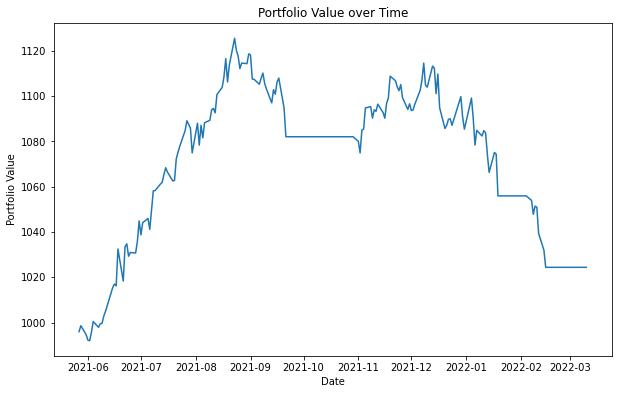

In [10]:
# 初始化对象
simulator = TradingSimulator(indicators, start_time=100, end_time=300, indicator_list=['sma_5', 'rsi_(14)', 'macd_(12,26)'])

# 计算回报
final_return = simulator.calculate_return()
print(f"Final Return: {final_return}")

# 绘制资产变化曲线
simulator.plot_portfolio()


In [11]:
import random
from itertools import combinations
from functools import reduce
from operator import mul

In [62]:
def generate_population(indicator_list, population_size=10, min_indicators=2, max_indicators=10):
    population = []
    for _ in range(population_size):
        n_indicators = random.randint(min_indicators, max_indicators)
        individual = random.sample(indicator_list, n_indicators)
        population.append(individual)
    return population

def fitness_function(individual, indicators, start_time, end_time):
    simulator = TradingSimulator(indicators, start_time, end_time, individual)
    score = simulator.calculate_return()
    return score

def crossover(parent1, parent2):
    common_elements = list(set(parent1).intersection(parent2))
    unique_elements1 = list(set(parent1).difference(parent2))
    unique_elements2 = list(set(parent2).difference(parent1))

    child1 = common_elements + random.sample(unique_elements1, len(unique_elements1) // 2)
    child2 = common_elements + random.sample(unique_elements2, len(unique_elements2) // 2)
    
    # 如果子代为空，从父代中各随机选择技术指标添加到子代中
    if len(child1) == 0:
        if len(common_elements):
            child1.append(random.choice(common_elements))
        if len(unique_elements1):
            child1.append(random.choice(unique_elements1))
        if len(unique_elements2):
            child1.append(random.choice(unique_elements2))
    if len(child2) == 0:
        if len(common_elements):
            child2.append(random.choice(common_elements))
        if len(unique_elements1):
            child2.append(random.choice(unique_elements1))
        if len(unique_elements2):
            child2.append(random.choice(unique_elements2))

    return child1, child2

def mutate(individual, indicator_list, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.choice(list(set(indicator_list).difference(individual)))
    return individual

In [63]:
def genetic_algorithm(indicators, indicator_list, start_time, end_time, population_size=100, generations=10, mutation_rate=0.25):
    population = generate_population(indicator_list, population_size)
    best_individuals = []
    best_individuals_set = set()

    for generation in range(generations):
        fitness_values = [fitness_function(ind, indicators, start_time, end_time) for ind in population]

        # Select the best individuals
        sorted_indices = sorted(range(len(fitness_values)), key=lambda k: fitness_values[k], reverse=True)
        best_individuals_candidate = [population[i] for i in sorted_indices[:10]]

        count = 0
        best_individuals = []
        best_individuals_set = set()
        for ind in best_individuals_candidate:
            ind_tuple = tuple(sorted(ind))
            if ind_tuple not in best_individuals_set:
                best_individuals.append(ind)
                best_individuals_set.add(ind_tuple)
                count += 1
            if count >= 10:
                break

        # Print the best individuals and their fitness values for the current generation
        print(f"代 {generation + 1}:")
        for i, individual in enumerate(best_individuals):
            print(f"参数组合 {i + 1}: {individual}")
            print(f"评分: {fitness_function(individual, indicators, start_time, end_time)}")
        print()

        # Create the next generation
        new_population = best_individuals
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(best_individuals, k=2)
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1, indicator_list, mutation_rate), mutate(child2, indicator_list, mutation_rate)])

        population = new_population

    return best_individuals


def test_best_individuals(best_individuals, indicators, start_time, end_time):
    fitness_values = [fitness_function(ind, indicators, start_time, end_time) for ind in best_individuals]
    return fitness_values

In [43]:
# Parameters
indicator_list = ['sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'rsi_(14)', 'stoch_(9,6)', 'macd_(12,26)', 'adx_(14)', 'cci_(14)', 'roc_(14)', 'bull/bear power_(13)']
train_start_time = random.randint(0, 575 - 300)
train_end_time = train_start_time + random.randint(100, 300)
test_start_time = train_end_time + 1
test_end_time = test_start_time + 14

In [45]:
train_start_time

94

In [46]:
train_end_time

356

In [64]:
# Run the genetic algorithm
best_individuals = genetic_algorithm(indicators, indicator_list, train_start_time, train_end_time)

代 1:
参数组合 1: ['bull/bear power_(13)', 'cci_(14)', 'rsi_(14)', 'adx_(14)']
评分: 1126.7830462341312
参数组合 2: ['roc_(14)', 'bull/bear power_(13)']
评分: 1058.5450224914553
参数组合 3: ['adx_(14)', 'cci_(14)', 'sma_10', 'rsi_(14)']
评分: 1043.613678039551
参数组合 4: ['adx_(14)', 'ema_5', 'macd_(12,26)', 'ema_10']
评分: 1037.9018883056638
参数组合 5: ['stoch_(9,6)', 'adx_(14)', 'macd_(12,26)', 'sma_10', 'rsi_(14)', 'sma_20']
评分: 1024.2338879699705
参数组合 6: ['macd_(12,26)', 'adx_(14)', 'bull/bear power_(13)', 'ema_20', 'sma_20', 'cci_(14)', 'ema_50', 'sma_50', 'ema_5']
评分: 1023.1318016357422
参数组合 7: ['sma_10', 'sma_50', 'ema_50', 'adx_(14)']
评分: 1017.086817504883
参数组合 8: ['stoch_(9,6)', 'sma_50', 'sma_20', 'cci_(14)', 'bull/bear power_(13)', 'adx_(14)', 'ema_50', 'rsi_(14)']
评分: 1015.5393635864257
参数组合 9: ['rsi_(14)', 'ema_10', 'ema_20', 'sma_20', 'adx_(14)', 'sma_50', 'macd_(12,26)', 'sma_5', 'ema_50']
评分: 1015.1748999328613
参数组合 10: ['stoch_(9,6)', 'macd_(12,26)', 'ema_5', 'cci_(14)', 'rsi_(14)', 'adx_(14)', 

In [65]:
# Test the best individuals
test_results = test_best_individuals(best_individuals, indicators, test_start_time, test_end_time)

In [66]:
# Print the results
for i, individual in enumerate(best_individuals):
    print(f"参数组合 {i + 1}: {individual}")
    print(f"训练集评分: {fitness_function(individual, indicators, train_start_time, train_end_time)}")
    print(f"测试集评分: {test_results[i]}")

参数组合 1: ['bull/bear power_(13)', 'cci_(14)', 'rsi_(14)', 'adx_(14)']
训练集评分: 1126.7830462341312
测试集评分: 940.5999755859375
参数组合 2: ['cci_(14)', 'rsi_(14)', 'stoch_(9,6)']
训练集评分: 1099.923691696167
测试集评分: 998.0
参数组合 3: ['cci_(14)']
训练集评分: 1099.923691696167
测试集评分: 998.0
参数组合 4: ['cci_(14)', 'rsi_(14)']
训练集评分: 1099.923691696167
测试集评分: 998.0
参数组合 5: ['cci_(14)', 'stoch_(9,6)']
训练集评分: 1099.923691696167
测试集评分: 998.0
参数组合 6: ['ema_5', 'adx_(14)']
训练集评分: 943.2699661254883
测试集评分: 944.3999938964844
参数组合 7: ['cci_(14)']
训练集评分: 1099.923691696167
测试集评分: 998.0
参数组合 8: ['cci_(14)', 'sma_5']
训练集评分: 629.5999221801758
测试集评分: 993.5999908447266
参数组合 9: ['cci_(14)', 'stoch_(9,6)']
训练集评分: 1099.923691696167
测试集评分: 998.0
参数组合 10: ['ema_50']
训练集评分: 1000.4060916290287
测试集评分: 998.0
参数组合 11: ['stoch_(9,6)']
训练集评分: 998.0
测试集评分: 998.0
参数组合 12: ['rsi_(14)']
训练集评分: 998.0
测试集评分: 998.0
参数组合 13: ['sma_50']
训练集评分: 985.5777983398439
测试集评分: 998.0
参数组合 14: ['ema_50', 'stoch_(9,6)']
训练集评分: 1000.4060916290287
测试集评分: 998.0
参数组合 15